# 1D Lax Tube

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/cfd_solver/mindspore_lax_tube.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/cfd_solver/mindspore_lax_tube.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/cfd_solver/lax_tube.ipynb)

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class*.

The shock tube problem is a common test for the accuracy of computational fluid codes, like Riemann solvers. The test consists of a one-dimensional Riemann problem with left and right states of an ideal gas.

## Problem Description

The definition of the Lax tube problem is:

$$
\frac{\partial}{\partial t} \left(\begin{matrix} \rho \\ \rho u \\ E \\\end{matrix} \right) + \frac{\partial}{\partial x} \left(\begin{matrix} \rho u \\ \rho u^2 + p \\ u(E + p) \\\end{matrix} \right) = 0
$$

$$
E = \frac{\rho}{\gamma - 1} + \frac{1}{2}\rho u^2
$$

where $\gamma = 1.4$ for ideal gas. The initial condition is

$$
\left(\begin{matrix} \rho \\ u \\ p \\\end{matrix}\right)_{x<0.5} = \left(\begin{matrix} 0.445 \\ 0.698 \\ 3.528 \\\end{matrix}\right), \quad
\left(\begin{matrix} \rho \\ u \\ p \\\end{matrix}\right)_{x>0.5} = \left(\begin{matrix} 0.5 \\ 0.0 \\ 0.571 \\\end{matrix}\right)
$$

The Neumann boundary condition is applied on both side of the tube.

The following `src` pacakage can be downloaded in [src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/cfd/lax/src).

In [1]:
from mindspore import context
from mindflow import load_yaml_config, vis_1d
from mindflow import cfd
from mindflow.cfd.runtime import RunTime
from mindflow.cfd.simulator import Simulator

from src.ic import lax_ic_1d

## Setting up the MindSpore Runtime Environment

Before running the program, the context should be configured. The commonly used parameters inside `context.set_context` are described as follows:

`mode` represents the execution mode. 'GRAPH' indicates the static graph mode, 'PYNATIVE' indicates the dynamic graph mode. For more details, please refer to the [MindSpore official website](https://www.mindspore.cn/docs/en/r2.0/design/dynamic_graph_and_static_graph.html?highlight=pynative). The default value is 'GRAPH'.

`save_graphs` indicates whether to save the computation graph. The default value is 'False'.

`device_target` represents the type of computing platform to be used, which can be either 'Ascend' or 'GPU'. The default value is 'GPU'.

`device_id` represents the number of the computing card to be used. It can be filled in according to the actual situation. The default value is 0.

In [2]:
context.set_context(mode=context.GRAPH_MODE, save_graphs=False, device_target="GPU", device_id=0)

## Reading Configuration File

This program provides multiple options for configuring the grid, materials, simulation time, boundary conditions, and numerical methods. These configurations can be set in the file named [numeric.yaml](./numeric.yaml). Users can choose different numerical methods according to their needs. The program supports the following numerical methods: WENO3, WENO5, and WENO7 for reconstruction, and Rsuanov, HLLC, and Roe for Riemann solvers.

In addition to directly setting the configurations in the file, you can also modify the following code to select the desired numerical methods. In the code block below, the second and third lines are where the numerical methods are set. If you prefer to specify the numerical methods directly in the configuration file, you can comment out these two lines of code.

In [3]:
config = load_yaml_config('numeric.yaml')
config["space_solver"]["convective_flux"]["reconstructor"] = "WENO5"
config["space_solver"]["convective_flux"]["riemann_computer"] = "Roe"

## Define Simulator and RunTime


In [4]:
simulator = Simulator(config)
runtime = RunTime(config['runtime'], simulator.mesh_info, simulator.material)

## Initial Condition

Initial condition is determined according to mesh coordinates.

In [5]:
mesh_x, _, _ = simulator.mesh_info.mesh_xyz()
pri_var = lax_ic_1d(mesh_x)
con_var = cfd.cal_con_var(pri_var, simulator.material)

## Run Simulation

Run CFD simulation with time marching.

In [6]:
while runtime.time_loop(pri_var):
    pri_var = cfd.cal_pri_var(con_var, simulator.material)
    runtime.compute_timestep(pri_var)
    con_var = simulator.integration_step(con_var, runtime.timestep)
    runtime.advance()

current time = 0.000000, time step = 0.001117
current time = 0.001117, time step = 0.001031
current time = 0.002148, time step = 0.001000
current time = 0.003148, time step = 0.000972
current time = 0.004120, time step = 0.000962
current time = 0.005082, time step = 0.000954
current time = 0.006036, time step = 0.000944
current time = 0.006980, time step = 0.000955
current time = 0.007935, time step = 0.000953
current time = 0.008888, time step = 0.000950
current time = 0.009838, time step = 0.000947
current time = 0.010785, time step = 0.000943
current time = 0.011728, time step = 0.000942
current time = 0.012670, time step = 0.000943
current time = 0.013613, time step = 0.000947
current time = 0.014560, time step = 0.000952
current time = 0.015512, time step = 0.000950
current time = 0.016462, time step = 0.000950
current time = 0.017412, time step = 0.000949
current time = 0.018361, time step = 0.000949
current time = 0.019310, time step = 0.000949
current time = 0.020258, time step

## Post Processing

You can view the density, pressure and velocity.

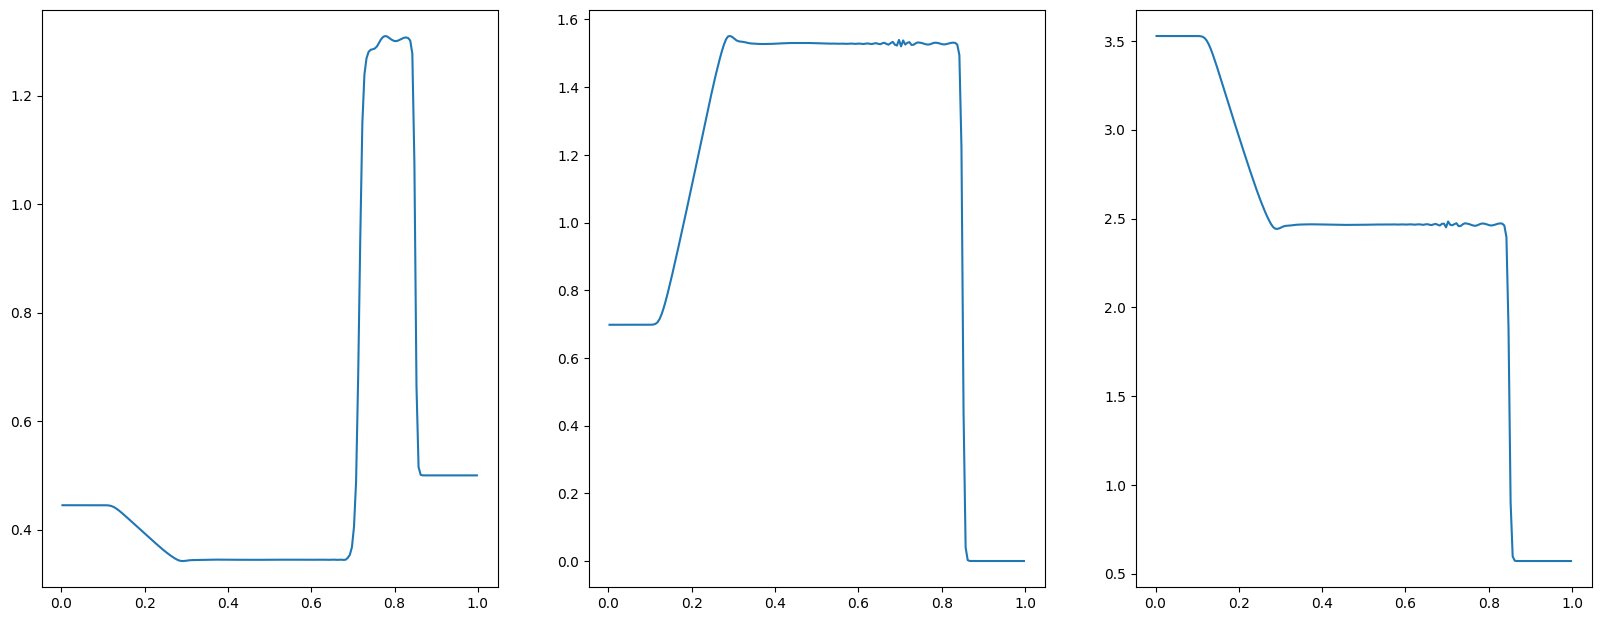

In [7]:
pri_var = cfd.cal_pri_var(con_var, simulator.material)
vis_1d(pri_var, 'lax.jpg')